In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create data set object
iris = load_iris()

In [3]:
# Convert to dataframe
iris_df = pd.DataFrame(data = np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

In [4]:
# Check out
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [104]:
# get features and labels from dataframe
X = iris_df.drop("target",axis=1).values
y = iris_df["target"].values

X_train = []
for i in range(len(X)):
    X_train.append([X[i], y[i]])
X_train

[[array([5.1, 3.5, 1.4, 0.2]), 0.0],
 [array([4.9, 3. , 1.4, 0.2]), 0.0],
 [array([4.7, 3.2, 1.3, 0.2]), 0.0],
 [array([4.6, 3.1, 1.5, 0.2]), 0.0],
 [array([5. , 3.6, 1.4, 0.2]), 0.0],
 [array([5.4, 3.9, 1.7, 0.4]), 0.0],
 [array([4.6, 3.4, 1.4, 0.3]), 0.0],
 [array([5. , 3.4, 1.5, 0.2]), 0.0],
 [array([4.4, 2.9, 1.4, 0.2]), 0.0],
 [array([4.9, 3.1, 1.5, 0.1]), 0.0],
 [array([5.4, 3.7, 1.5, 0.2]), 0.0],
 [array([4.8, 3.4, 1.6, 0.2]), 0.0],
 [array([4.8, 3. , 1.4, 0.1]), 0.0],
 [array([4.3, 3. , 1.1, 0.1]), 0.0],
 [array([5.8, 4. , 1.2, 0.2]), 0.0],
 [array([5.7, 4.4, 1.5, 0.4]), 0.0],
 [array([5.4, 3.9, 1.3, 0.4]), 0.0],
 [array([5.1, 3.5, 1.4, 0.3]), 0.0],
 [array([5.7, 3.8, 1.7, 0.3]), 0.0],
 [array([5.1, 3.8, 1.5, 0.3]), 0.0],
 [array([5.4, 3.4, 1.7, 0.2]), 0.0],
 [array([5.1, 3.7, 1.5, 0.4]), 0.0],
 [array([4.6, 3.6, 1. , 0.2]), 0.0],
 [array([5.1, 3.3, 1.7, 0.5]), 0.0],
 [array([4.8, 3.4, 1.9, 0.2]), 0.0],
 [array([5. , 3. , 1.6, 0.2]), 0.0],
 [array([5. , 3.4, 1.6, 0.4]), 0.0],
 

In [95]:
X_train, X_test = train_test_split(X_train,test_size=0.30,random_state=42
                                                    ,shuffle=True)

In [96]:
print(len(X_test))

45


In [76]:
valid_size = 0.2
num_train = len(X_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [97]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size=5)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=5)

In [98]:
len(train_loader)

21

In [99]:
len(test_loader)

9

In [123]:
from torch import nn
import torch.nn.functional as F
from torch import optim

class Model(nn.Module):
    def __init__(self, input_features=4, hidden_layer1=6, hidden_layer2=6, output_features=3):
        super().__init__()
        self.fc1 = nn.Linear(input_features,hidden_layer1)                  
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)                  
        self.out = nn.Linear(hidden_layer2, output_features)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(x, dim=1)
        return x

In [124]:
model = Model()
model

Model(
  (fc1): Linear(in_features=4, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=6, bias=True)
  (out): Linear(in_features=6, out_features=3, bias=True)
)

In [125]:
# CrossEntropy as loss function
# use Adam as optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [126]:
epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for feature,label in train_loader:
        optimizer.zero_grad()
        y = model(feature.float())
        loss = criterion(y,label.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            for feature,label in test_loader:
                y = model(feature.float())
                test_loss += criterion(y, label.long())
                
                ps = torch.exp(y)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == label.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/30..  Training Loss: 1.349..  Test Loss: 1.206..  Test Accuracy: 0.711
Epoch: 2/30..  Training Loss: 1.165..  Test Loss: 1.085..  Test Accuracy: 0.711
Epoch: 3/30..  Training Loss: 1.049..  Test Loss: 0.968..  Test Accuracy: 0.978
Epoch: 4/30..  Training Loss: 0.946..  Test Loss: 0.849..  Test Accuracy: 0.711
Epoch: 5/30..  Training Loss: 0.835..  Test Loss: 0.726..  Test Accuracy: 0.711
Epoch: 6/30..  Training Loss: 0.739..  Test Loss: 0.618..  Test Accuracy: 0.800
Epoch: 7/30..  Training Loss: 0.655..  Test Loss: 0.542..  Test Accuracy: 0.800
Epoch: 8/30..  Training Loss: 0.590..  Test Loss: 0.481..  Test Accuracy: 0.889
Epoch: 9/30..  Training Loss: 0.538..  Test Loss: 0.436..  Test Accuracy: 0.889
Epoch: 10/30..  Training Loss: 0.497..  Test Loss: 0.400..  Test Accuracy: 0.978
Epoch: 11/30..  Training Loss: 0.462..  Test Loss: 0.369..  Test Accuracy: 0.978
Epoch: 12/30..  Training Loss: 0.433..  Test Loss: 0.344..  Test Accuracy: 0.978
Epoch: 13/30..  Training Loss: 0.407.

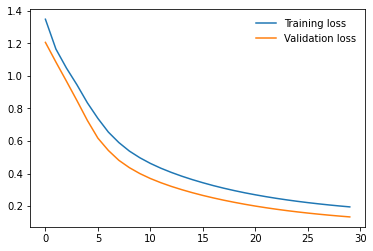

In [127]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)